In [7]:
# Cross entropy loss version of the code
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Notes:
1. For cross entropy loss we do not need to do one hot encoding for the labels
2. We do not need to use the softmax activation function as the cross entropy loss function already includes it.
3. 

Mini-batch training (e.g., batch size 64 on MNIST):
##
60,000 training examples / 64 ≈ 937 mini-batches
937 weight updates per epoch
In 10 epochs, that’s ~9,370 total updates
Full-batch training:
##
60,000 training examples in one batch
1 weight update per epoch
In 10 epochs, that’s only 10 total updates
Even though both are “10 epochs,” mini-batch training is effectively doing way more frequent (and often more helpful) gradient steps. That’s why it can reach high accuracy in far fewer epochs.

### fewer updates per epoch = slower convergence per epoch


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# loading the data
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

testing_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

In [9]:
print(len(training_data)) #The amount of samples in the dataset

#Note this is a tuple
#training_data[0]

#so we can access the label by 
image, label = training_data[0]  # Sample has 28x28 pixels
print(label) #this is the label for the data

image.shape #this is the shape of the image

60000
5


torch.Size([1, 28, 28])

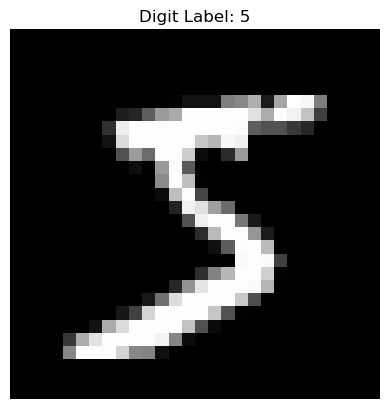

In [10]:
image, label = training_data[0]  # Sample has 28x28 pixels

# Display the image using matplotlib
plt.imshow(image.squeeze(), cmap='gray')  # Remove single channel with squeeze()
plt.title(f"Digit Label: {label}")
plt.axis('off')  # Turn off axis
plt.show()

In [11]:
# Note we are doing MLP (Multi Layer Perceptron) method and not CNN (Convolutional Neural Network)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            #28*28 is the number of features which is all of the pixels inside of an image and this will be done for each image
            nn.Linear(in_features=28*28, out_features=20), #outfeatures is the neurons in the next layer that we want to have.
            nn.ReLU(), #relu is the activation function
            nn.Linear(20, 10)
        )
        

    def forward(self, x):
        #take in all the x features and pass it through the layers with all the rows.
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


## Dataloader

We can put the dataset obejcts inside of a dataloader class to specify a batch_size
the first dimension will be equal to the batch size.

In [12]:
train_dataloader = DataLoader(training_data, batch_size=64, drop_last=True)
test_dataloader = DataLoader(testing_data, batch_size=64, drop_last=True)


# #Dataloader is a way to load the data in batches
# for batch in train_dataloader:
#     print(batch) #batches are in size of 64

for batch in train_dataloader:
    images, labels = batch
    print(images.shape)  # e.g., torch.Size([64, 1, 28, 28])
    print(labels.shape)  # e.g., torch.Size([64])
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [30]:
class TrainingData(Dataset):
    def __init__(self):
        #using mean squared error loss function similar to prev implementation
        self.lossfn = nn.CrossEntropyLoss()

    def gradient_descent(self, model, dataloader, optimizer):
        ''' we are minimizing the loss function for each batch
        model: the NN model that we used to make a prediction
        optimizer: the optimizer that we used to update the weights
        train_dataloader: the dataloader that we used to load the data

        '''
        size = len(dataloader)

        # Enumeration step gets the index of the current batch (X,y) X is the tenor containing the input feature ie image and y is the label.
        for batch, (X, y) in enumerate(dataloader):
            prediction = model.forward(X)
            # print(prediction.shape)
            # print(y.shape)
            loss = self.lossfn(prediction, y)

            #Perform the backpropagation step for each layer in the model
            #Calculates all of the partial derivatives of the loss function with respect to the weights and biases
            loss.backward()

            optimizer.step()
            #prevents the gradient from accumulating
            optimizer.zero_grad()
            correct = 0
            total = 1
            _, predicted = torch.max(prediction.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                
                
        accuracy = 100 * correct / total 
        print(f"Accuracy: {accuracy:>7f}  [{current:>5d}/{size:>5d}]")

In [31]:
epochs = 10
learning_rate = 0.01

model = NeuralNetwork()


optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
TrainingData = TrainingData()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    TrainingData.gradient_descent(model, train_dataloader, optimizer)

print("Done!")

Epoch 1
-------------------------------
loss: 2.365488  [    0/  937]
loss: 1.527867  [ 6400/  937]
loss: 1.182376  [12800/  937]
loss: 0.790609  [19200/  937]
loss: 0.552362  [25600/  937]
loss: 0.555169  [32000/  937]
loss: 0.441997  [38400/  937]
loss: 0.610332  [44800/  937]
loss: 0.550044  [51200/  937]
loss: 0.496991  [57600/  937]
Accuracy: 86.153846  [57600/  937]
Epoch 2
-------------------------------
loss: 0.411821  [    0/  937]
loss: 0.307357  [ 6400/  937]
loss: 0.358524  [12800/  937]
loss: 0.417523  [19200/  937]
loss: 0.281812  [25600/  937]
loss: 0.377521  [32000/  937]
loss: 0.282143  [38400/  937]
loss: 0.444355  [44800/  937]
loss: 0.450510  [51200/  937]
loss: 0.449160  [57600/  937]
Accuracy: 87.692308  [57600/  937]
Epoch 3
-------------------------------
loss: 0.290754  [    0/  937]
loss: 0.250213  [ 6400/  937]
loss: 0.283116  [12800/  937]
loss: 0.371281  [19200/  937]
loss: 0.232635  [25600/  937]
loss: 0.340794  [32000/  937]
loss: 0.252266  [38400/  937]
